In [1]:
%matplotlib notebook

import re
import os
import sys
import math
import pickle
import pandas as pd
import numpy as np
from itertools import product
from scipy.stats import sem, norm
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

In [2]:
def get_label_name(run_dict):
    value_translation = {"decoherence": "dec", "fixed_lde_attempts": "decoupling"}
    keep_key = ['pg', 'pn', 'pm', 'pm_1']
    name = ""
    for key, value in run_dict.items():
        if value is not False:
            if key in value_translation:
                value = value_translation[key]
            name += "{}{}, ".format(key + "=" if key in keep_key else "", str(value).replace("_swap", ""))

    name = name.strip(", ")

    return name

In [3]:
def keep_rows_to_evaluate(df, ev_values):
    for key, values in ev_values.items():
        if values and 'REMOVE' not in values:
            df = df[df[key].isin(values)]
        elif 'REMOVE' not in values:
            ev_values[key] = set(df[key])

    if df.empty:
        print("The combination of values does not exist in the dataframe!", file=sys.stderr)
        raise
        
    return df

In [4]:
def plot_style(title=None, xlabel=None, ylabel=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.08, bottom=0.08, right=.95, top=.95)
    ax.grid(color='w', linestyle='-', linewidth=2)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    for key, arg in kwargs.items():
        func = getattr(ax, f"set_{key}")
        func(arg)
    ax.patch.set_facecolor('0.95')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig, ax

In [5]:
def filter_evaluate_values(values, x_axis):
    new_dict = {}
    for key, value in values.items():
        if len(value) > 1 and key != x_axis:
            new_dict[key] = value
        elif len(value) == 1 and key != x_axis:
            print("[+] {}={} holds for all displayed values".format(key, value.pop()))

    return new_dict

In [6]:
def plot_non_local_cnot_fidelity(df, x_axis, evaluate_values, spread=False,
                                 ent_fid=False):
    fig, ax = plot_style(title="Non-local CNOT gate", xlabel=x_axis, ylabel="Average fidelity")

    df = df.reset_index()
    df = keep_rows_to_evaluate(df, evaluate_values)
    evaluate_values = filter_evaluate_values(evaluate_values, x_axis)
    df = df.set_index(list(evaluate_values.keys()))
    df = df.sort_index()

    for index_tuple in product(*evaluate_values.values()):
        if index_tuple in df.index:
            index_dict = dict(zip(evaluate_values.keys(), index_tuple))
            x_data = df.loc[index_tuple, x_axis]
            ax.errorbar(x_data,
                        df.loc[index_tuple, 'avg_fidelity'],
                        yerr=None if not spread else [df.loc[index_tuple, 'fid_std_l'], df.loc[index_tuple, 'fid_std_r']],
                        ms=8,
                        fmt='-o',
                        capsize=8,
                        label=get_label_name(index_dict))
            if ent_fid:
                ax.errorbar(x_data,
                            df.loc[index_tuple, 'fid_entanglement'],
                            fmt='-o',
                            label="{} - {}".format(get_label_name(index_dict), "$F_{e}$"))
            ax.set_xlim(max(x_data) + 0.001, min(x_data) - 0.001)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, prop={'size': 18})
        plt.show()

In [7]:
def main(x_axis, evaluate_values, spread, ent_fid):
    dataframe = pd.read_csv('non_local_cnot_full.csv', sep=';', float_precision='round_trip')
    
    plot_non_local_cnot_fidelity(dataframe, x_axis, evaluate_values, spread=spread,
                                 ent_fid=ent_fid)

<IPython.core.display.Javascript object>


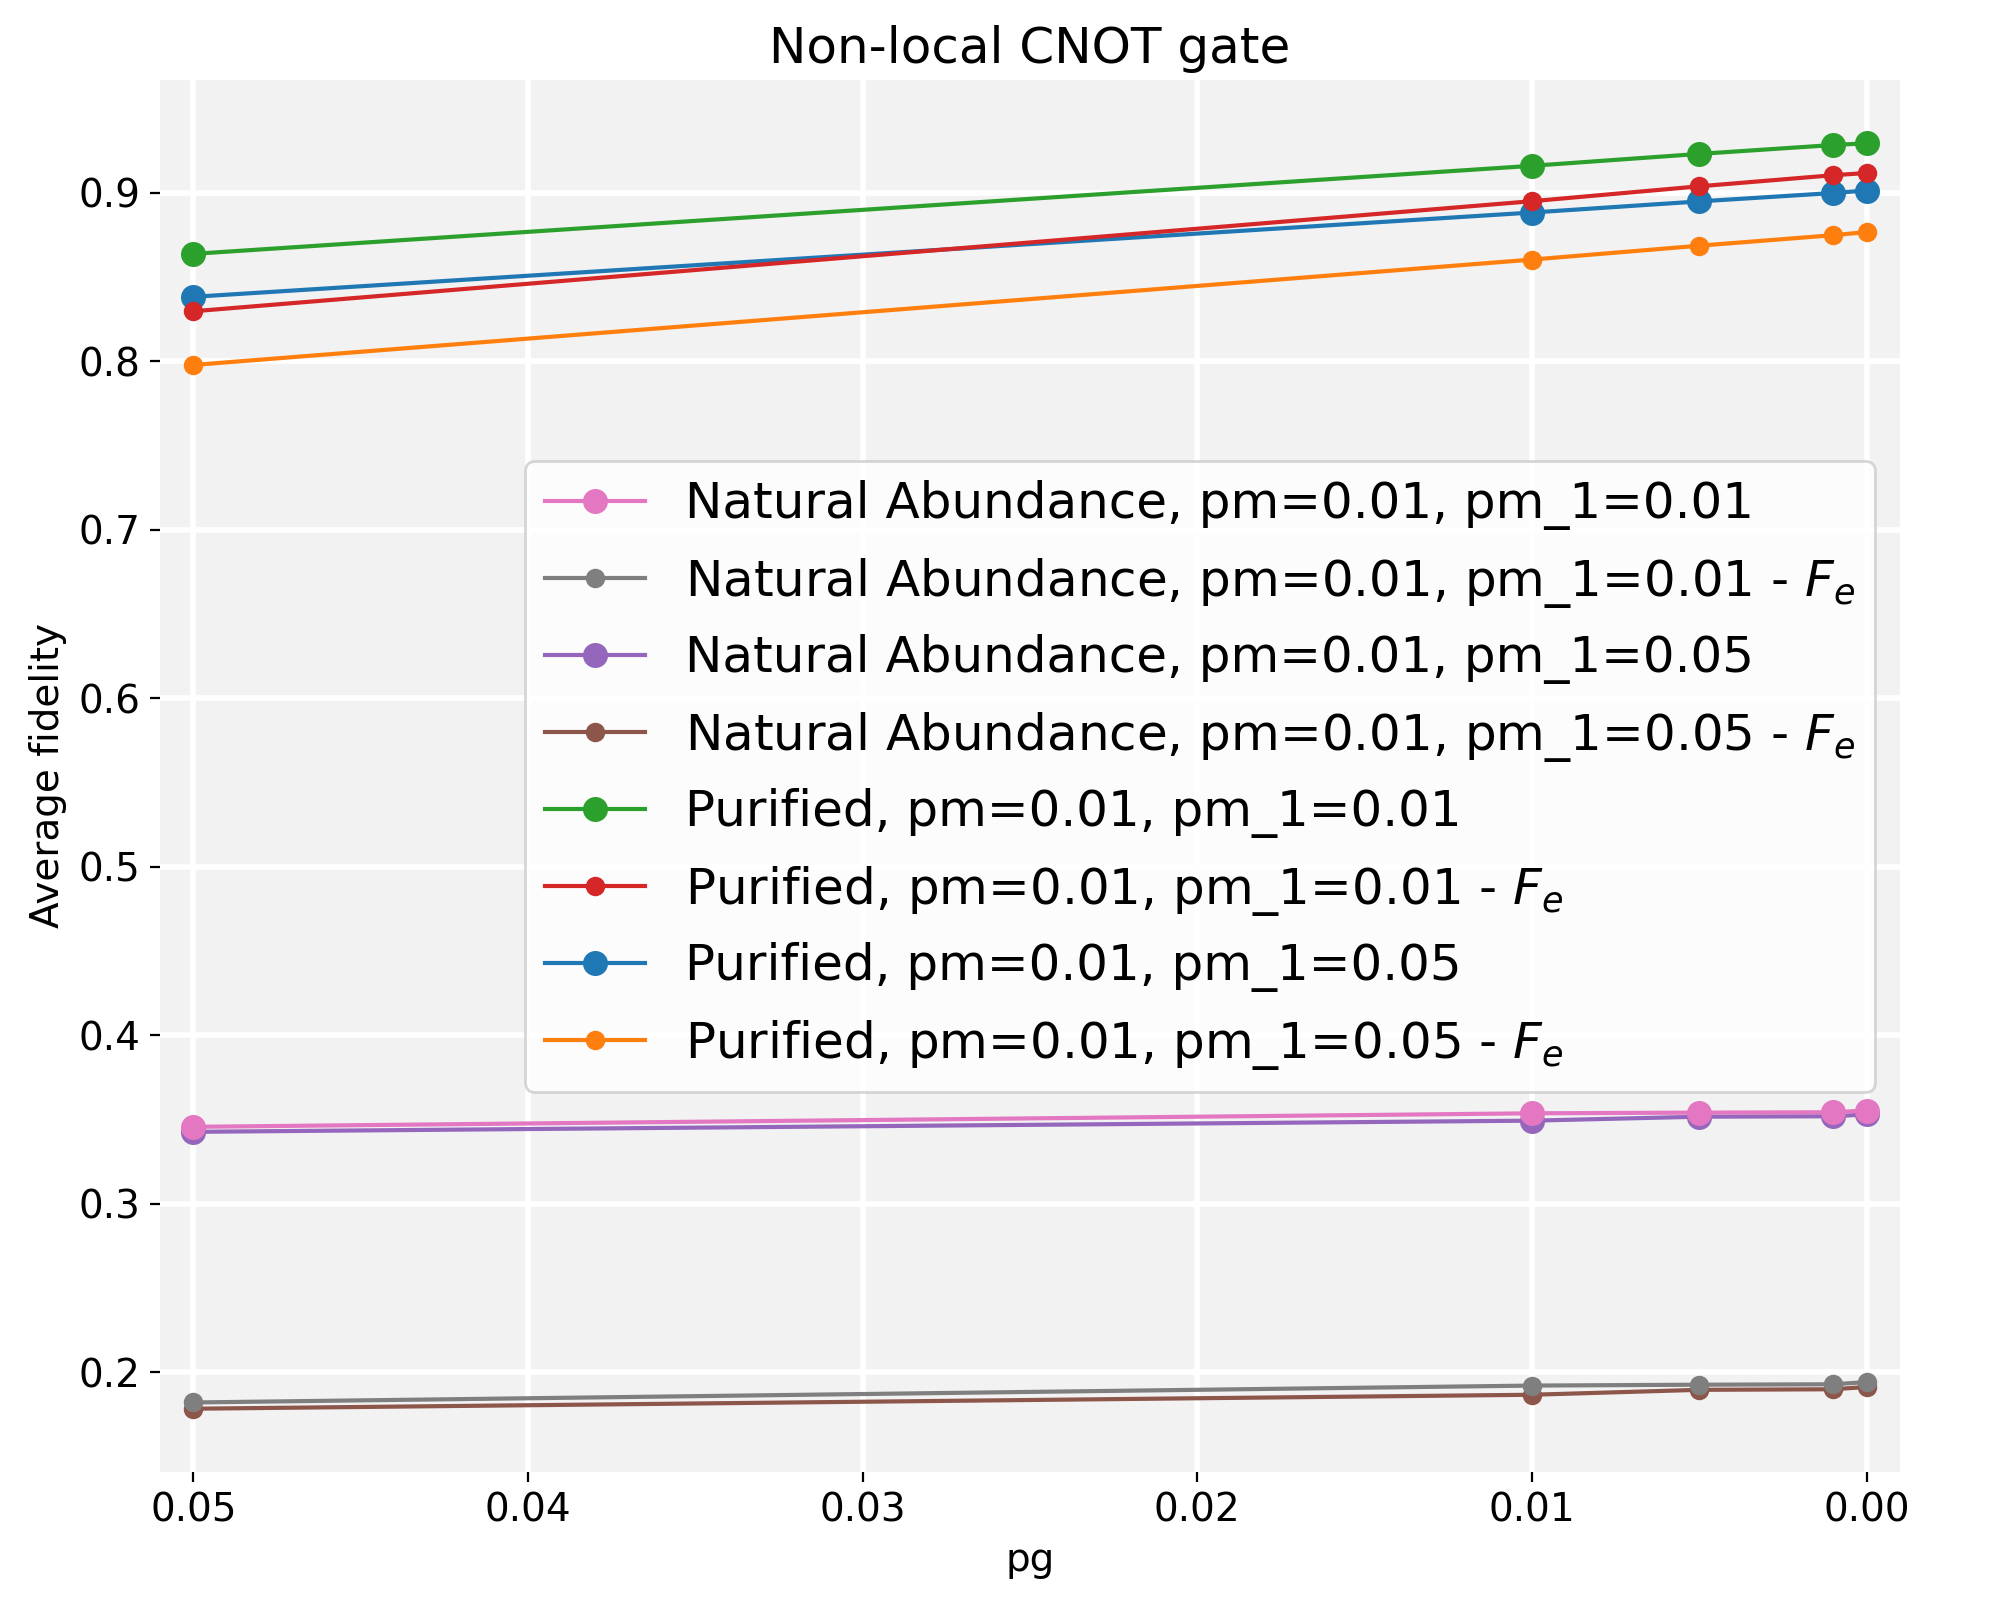

[+] decoherence=True holds for all displayed values
[+] fixed_lde_attempts=2000 holds for all displayed values
[+] lde_success=0.0001 holds for all displayed values
[+] pn=0.05 holds for all displayed values


In [8]:
###### USER INPUT ########

spread = False
ent_fid = True

evaluate_values = {'node':                  [],
                   'decoherence':           [True],
                   'fixed_lde_attempts':    [2000],
                   'lde_success':           [],
                   'pg':                    [],
                   'pm':                    [],
                   'pm_1':                  [],
                   'pn':                    [0.05]
                   }
x_axis = "pg"

main(x_axis, evaluate_values, spread, ent_fid)